In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


In [63]:
epochs = 10
image_size = (32, 32) # h x w
batch_size = 32

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_splitted, x_val, y_train_splitted, y_val =\
    train_test_split(x_train, y_train, test_size=0.1, random_state=42)

x_train_splitted = (x_train_splitted - 127.5) / 127.5 #Normalizing
x_val = (x_val - 127.5) / 127.5 #Normalizing
x_test = (x_test - 127.5) / 127.5 #Normalizing

dataset_train = tf.data.Dataset.from_tensor_slices(
    (x_train_splitted, tf.reshape(tf.one_hot(y_train_splitted, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

dataset_validation = tf.data.Dataset.from_tensor_slices(
    (x_val, tf.reshape(tf.one_hot(y_val, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices(
    (x_test, tf.reshape(tf.one_hot(y_test, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

In [64]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [65]:
inception_model = keras.applications.inception_v3.InceptionV3(
    input_shape=(299, 299, 3),
    weights='imagenet',
    include_top=False
)

In [66]:
image_batch, label_batch = next(iter(dataset_train))
print(image_batch.shape, label_batch.shape)
resized = tf.image.resize(image_batch, [299, 299], preserve_aspect_ratio=True, method='nearest')

feature_batch = inception_model(resized)
print(feature_batch.shape)
# (32, 8, 8, 2048) kimenete lesz a képeknek

(32, 32, 32, 3) (32, 10)
(32, 8, 8, 2048)


2022-04-24 08:48:16.500772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [67]:
# Freezing the base model
inception_model.trainable = False

Important note about BatchNormalization layers

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [68]:
inception_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [69]:
# Az összerakott modell
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
resized = tf.image.resize(
    x, [299, 299],
    preserve_aspect_ratio=True, method='nearest'
)
x = inception_model(resized, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(10)(x)
outputs = keras.layers.Activation("softmax")(x)
model = keras.Model(inputs, outputs)

In [70]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [71]:
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
tf.image.resize_2 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2049

In [72]:
len(model.trainable_variables)


2

In [73]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(dataset_validation)


2022-04-24 08:48:25.503247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


156/156 [==============================] - 14s 68ms/step - loss: 2.6055 - accuracy: 0.0877


In [74]:
print("initial loss: {:.4f}".format(loss0))
print("initial accuracy: {:.4f}".format(accuracy0))

initial loss: 2.6055
initial accuracy: 0.0877


In [75]:
history = model.fit(dataset_train,
                    epochs=initial_epochs,
                    validation_data=dataset_validation)

Epoch 1/10
1406/1406 [==============================] - 111s 75ms/step - loss: 1.5227 - accuracy: 0.4712 - val_loss: 0.8325 - val_accuracy: 0.7796
Epoch 2/10
1406/1406 [==============================] - 105s 75ms/step - loss: 1.1322 - accuracy: 0.6106 - val_loss: 0.6605 - val_accuracy: 0.8083
Epoch 3/10
1406/1406 [==============================] - 106s 75ms/step - loss: 1.0478 - accuracy: 0.6352 - val_loss: 0.5972 - val_accuracy: 0.8191
Epoch 4/10
1406/1406 [==============================] - 105s 75ms/step - loss: 1.0074 - accuracy: 0.6491 - val_loss: 0.5602 - val_accuracy: 0.8279
Epoch 5/10
1406/1406 [==============================] - 106s 75ms/step - loss: 0.9729 - accuracy: 0.6608 - val_loss: 0.5388 - val_accuracy: 0.8325
Epoch 6/10
1406/1406 [==============================] - 106s 75ms/step - loss: 0.9573 - accuracy: 0.6655 - val_loss: 0.5247 - val_accuracy: 0.8341
Epoch 7/10
1406/1406 [==============================] - 107s 76ms/step - loss: 0.9458 - accuracy: 0.6700 - val_loss: 0

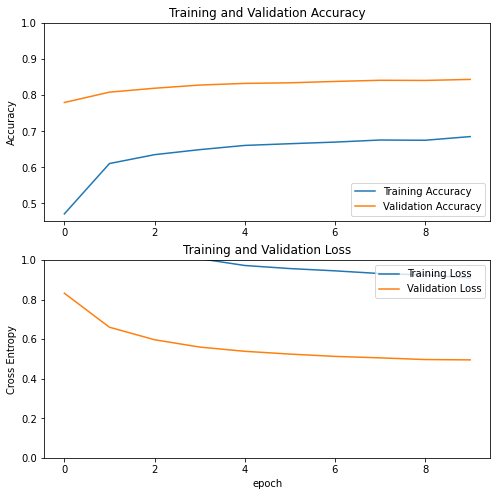

In [76]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [77]:
loss, accuracy = model.evaluate(dataset_test)
print('Test accuracy :', accuracy)


312/312 [==============================] - 21s 67ms/step - loss: 0.5097 - accuracy: 0.8394
Test accuracy : 0.8394430875778198


In [78]:
model.save("cifar10Classifier.h5")